In [1]:
import pynsx as nsx
import math
import numpy as np
from matplotlib import pyplot as plt
from os import path

In [2]:
def plot_I_vs_q(peak_list):
    qs = []
    Is = []
    
    for peak in peak_list:
        q = np.linalg.norm(peak.getQ().rowVector())
        I = peak.getCorrectedIntensity().value()
        qs.append(q)
        Is.append(I)
    
    plt.figure(figsize=(10,10))
    plt.scatter(qs, Is)
    plt.show()
    
def plot_dq_vs_frame(peak_list):
    dqs = []
    frames = []
    
    for i in range(len(peak_list)):
        peak = peak_list[i]
        obs_q = peak.getQ().rowVector()
        uc = peak.activeUnitCell()
        bu = uc.reciprocalBasis()
        hkl = uc.getIntegerMillerIndices(peak.getQ())
        pred_q = hkl.dot(bu)
        assert(pred_q.shape == obs_q.shape)
        dq = np.linalg.norm(pred_q-obs_q)
        
        dqs.append(dq)
        frames.append(peak.getShape().center()[2])
        
    plt.figure(figsize=(10,10))
    plt.scatter(frames, dqs)
    plt.show()
    
def plot_dx_vs_frame(peak_list, outlier=20):
    dxs = []
    frames = []
    
    for i in range(len(peak_list)):
        peak = peak_list[i]
        obs_x = peak.getShape().center()
        uc = peak.activeUnitCell()
        bu = uc.reciprocalBasis()
        hkl = uc.getIntegerMillerIndices(peak.getQ())
        pred_q = hkl.dot(bu)
        
        predictor = nsx.PeakPredictor(peak.data())
        ellipsoid = nsx.Ellipsoid(pred_q.transpose(), 100.0*np.identity(3)) 
        
        #hkls = nsx.MillerIndexList()
        #hkls.push_back()
  
        #print(hkl)
        preds = predictor.predictPeaks([nsx.MillerIndex(int(hkl[0,0]), int(hkl[0,1]), int(hkl[0,2]))], uc.reciprocalBasis())
            
        if len(preds) != 1:
            peak.setSelected(False)
            continue
            
        dx = np.linalg.norm(obs_x - preds[0].getShape().center())
        
        if (dx > outlier):
            peak.setSelected(False)
            continue
        
        dxs.append(dx)
        frames.append(peak.getShape().center()[2])

        
    print("npred", len(dxs))
    plt.figure(figsize=(10,10))
    plt.scatter(frames, dxs)
    plt.show()
    
def find_batch(peak, batches):
    z = peak.getShape().center()[2,0]
    
    for b in batches:
        if b.contains(z):
            return b
        
    return None
    
def reindex(peak_list, batches):          
    new_peaks = []
    
    for peak in peak_list:
        
        batch = find_batch(peak, batches)
        
        if batch is None:
            continue
        
        hkl = np.array([[0.,0.,0.]])
        uc = batch.cell()
        
        if uc.getMillerIndices(peak.getQ(), hkl):
            peak.addUnitCell(uc, True)
            new_peaks.append(peak)
            
    return new_peaks

def compute_statistics(peak_list, group, friedel):
    merged = nsx.MergedData(group, friedel)
    for peak in peak_list:
        if peak.isSelected():
            merged.addPeak(peak)
            
    r = nsx.RFactor()
    cc = nsx.CC()
    
    r.calculate(merged)
    cc.calculate(merged)
    
    stats = {}
    stats['CChalf'] = cc.CChalf()
    stats['CCtrue'] = cc.CCstar()
    stats['Rmeas'] = r.Rmeas()
    stats['Rmerge'] = r.Rmerge()
    stats['Rpim'] = r.Rpim()
    
    return stats

def num_selected_peaks(peaks):
    num_selected = 0
    
    for peak in peaks:
        if peak.isSelected():
            num_selected += 1
            
    return num_selected
    
def filter_peaks(peaks):
    for peak in peaks:
        if not peak.isSelected():
            continue
            
        if peak.pValue() > 1e-3:
            peak.setSelected(False)
            continue
            
        d = 1.0 / np.linalg.norm(peak.getQ())
        
        if d > 50.0 or d < 2.1:
            peak.setSelected(False)
            continue
            
        profile = nsx.Profile()
        
        if profile.fit(peak.getIntegration().getProjectionPeak()) == False:
            peak.setSelected(False)
            continue
        
def remove_deselected(data):
    peaks = data.getPeaks()
    
    for peak in peaks:
        if not peak.isSelected():
            data.removePeak(peak)

In [3]:
expt = nsx.Experiment('test', 'BioDiff2500')
diff = expt.getDiffractometer()
filename = path.expanduser("~/data/biodiff/p11202.hdf")
reader = nsx.HDF5DataReader(filename, diff)
data = nsx.DataSet(reader, diff)
expt.addData(data)

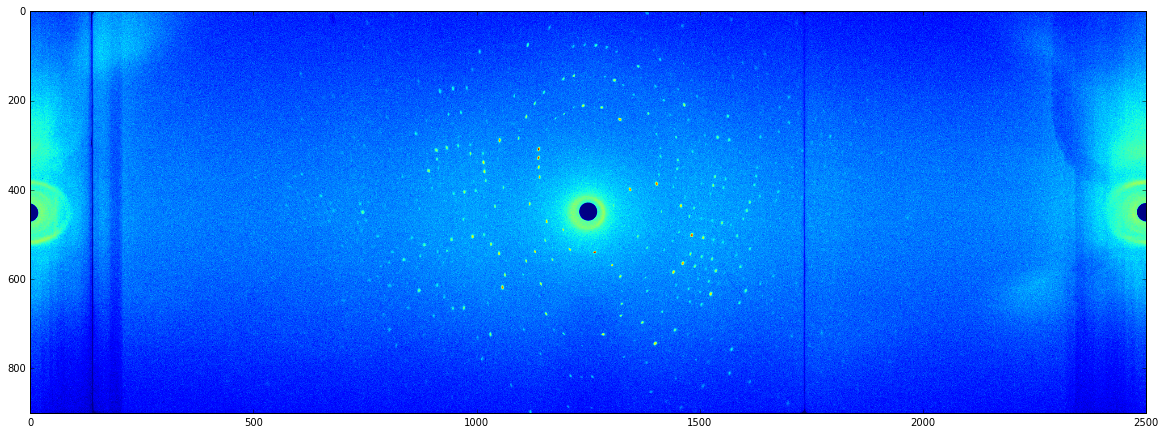

In [4]:
plt.figure(figsize=(20,10))
plt.imshow(np.log(data.getFrame(0)))
plt.show()

In [5]:
kernel = nsx.AnnularKernel(data.getNRows(), data.getNCols())
kernel_image = kernel.getKernel()
convolver = nsx.Convolver()
convolver.setKernel(kernel_image)

In [6]:
finder = nsx.PeakFinder()
finder.setConvolver(convolver)
finder.setMinComponents(30)
finder.setMaxComponents(10000)
finder.setIntegrationConfidence(0.98)
finder.setSearchConfidence(0.67)
finder.setThresholdType(1)
finder.setThresholdValue(80.0)
finder.setKernel(kernel)

In [7]:
peaks = finder.find([data])
print(peaks.size())

9203


In [8]:
data.integratePeaks(peaks, 3.5, 6.0, nsx.ProgressHandler())

In [9]:
for peak in peaks:
    inten = peak.getCorrectedIntensity()
    
    if not peak.isSelected():
        continue
    
    if (inten.sigma() < 1.0):
        peak.setSelected(False)

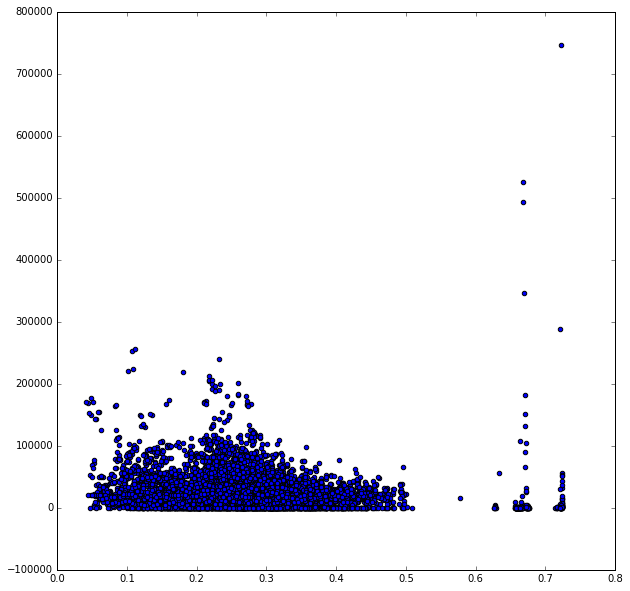

In [10]:
plot_I_vs_q(peaks)

7823


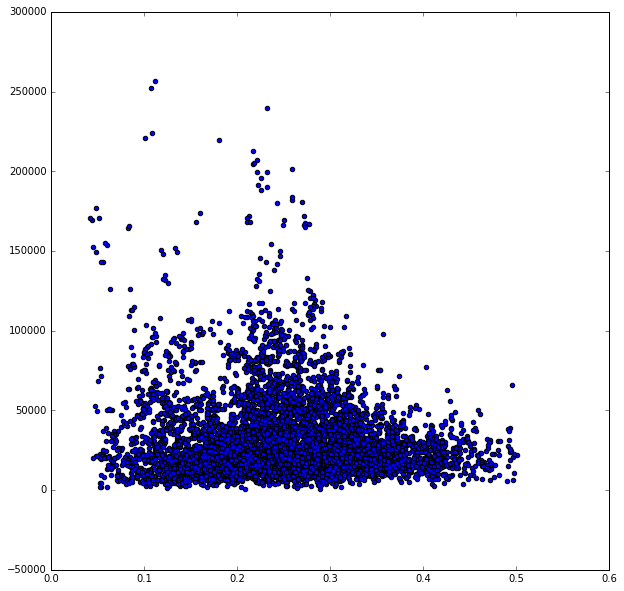

In [11]:
# clean up peaks
good_peaks = []

for peak in peaks:
    I = peak.getCorrectedIntensity().value()
    sigma = peak.getCorrectedIntensity().sigma()
    
    # keep only selected peaks
    if not peak.isSelected():
        continue
    
    # keep only strong peaks for autoindex
    if I < 1.0*sigma:
        continue
        
    d = 1.0 / np.linalg.norm(peak.getQ().rowVector())
    
    # keep peaks only in specified d range
    if d > 40.0 or d < 1.8:
        continue
        
    good_peaks.append(peak)
    
print(len(good_peaks))
plot_I_vs_q(good_peaks)

In [12]:
indexer = nsx.AutoIndexer(nsx.ProgressHandler())

for peak in good_peaks:
    indexer.addPeak(peak)

print("auto indexing", len(good_peaks), "peaks")
        
params = nsx.IndexerParameters()
handler = nsx.ProgressHandler()
indexer.autoIndex(params)

soln = indexer.getSolutions()[0]
assert(soln[1] > 92.0)

uc = nsx.UnitCell(soln[0])
sample = diff.getSample()
sample.addUnitCell(uc)

indexed_peaks = []

for peak in good_peaks:
    hkl = np.array([[0.,0.,0.]])
    if uc.getMillerIndices(peak.getQ(), hkl):
        peak.addUnitCell(uc, True)
        indexed_peaks.append(peak)
    
ch = uc.character()
print("indexed", len(indexed_peaks), "of", len(good_peaks))
print("found unit cell with parameters: ")
print("a: ", ch.a)
print("b: ", ch.b)
print("c: ", ch.c)
print("alpha: ", ch.alpha)
print("beta: ", ch.beta)
print("gamma: ", ch.gamma)

auto indexing 7823 peaks
indexed 7656 of 7823
found unit cell with parameters: 
a:  57.00191878198831
b:  60.67602570453978
c:  69.22490519204162
alpha:  1.5707963267948966
beta:  1.5707963267948966
gamma:  1.5707963267948961


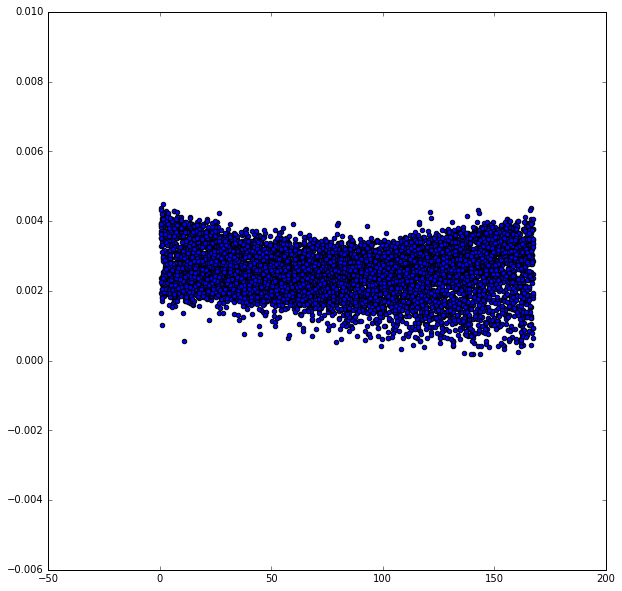

npred 7586


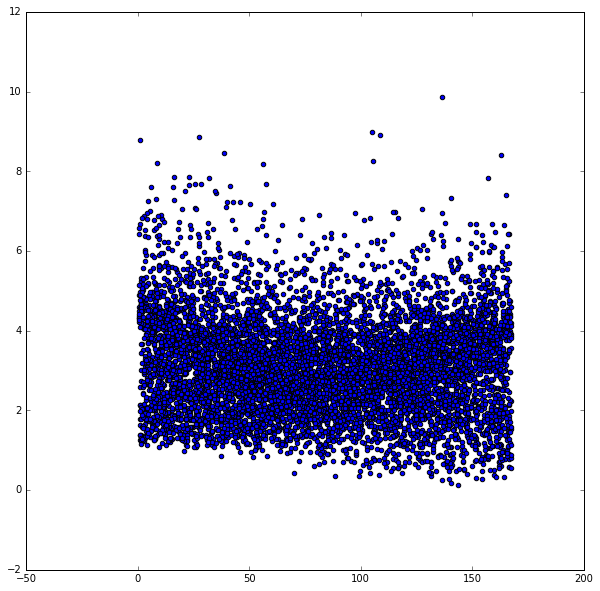

In [13]:
plot_dq_vs_frame(indexed_peaks)
plot_dx_vs_frame(indexed_peaks, 10)

In [14]:
nbatches = int(data.getNFrames() / 15)
states = data.getInstrumentStates()

refiner = nsx.Refiner(uc, indexed_peaks, nbatches)

refiner.refineSamplePosition(states)
refiner.refineKi(states)
refiner.refineSampleOrientation(states)
#refiner.refineU()
refiner.refineB()

success = refiner.refine(200)

print("refinement successful:", success)

refinement successful: True


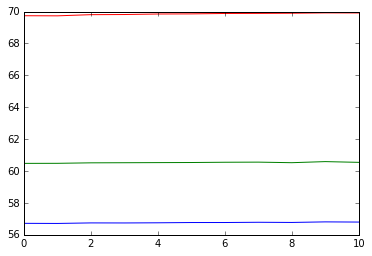

In [15]:
abc = []

for b in refiner.batches():
    ch = b.cell().character()
    abc.append([ch.a, ch.b, ch.c])
    
plt.plot([a[0] for a in abc])
plt.plot([a[1] for a in abc])
plt.plot([a[2] for a in abc])
plt.show()

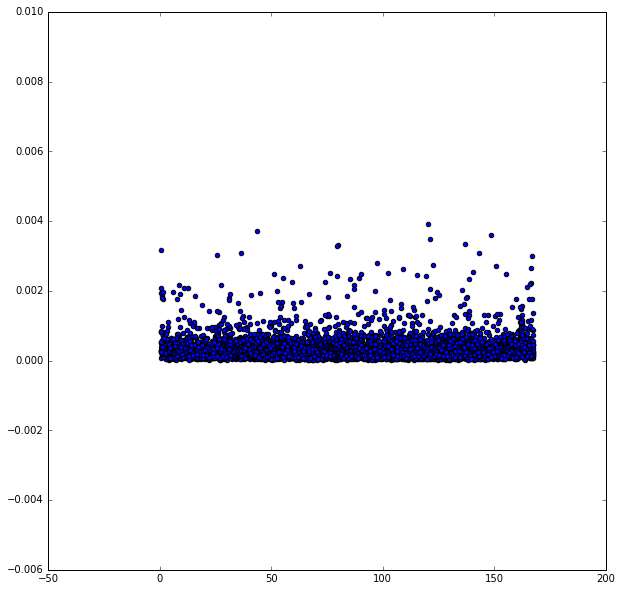

npred 7591


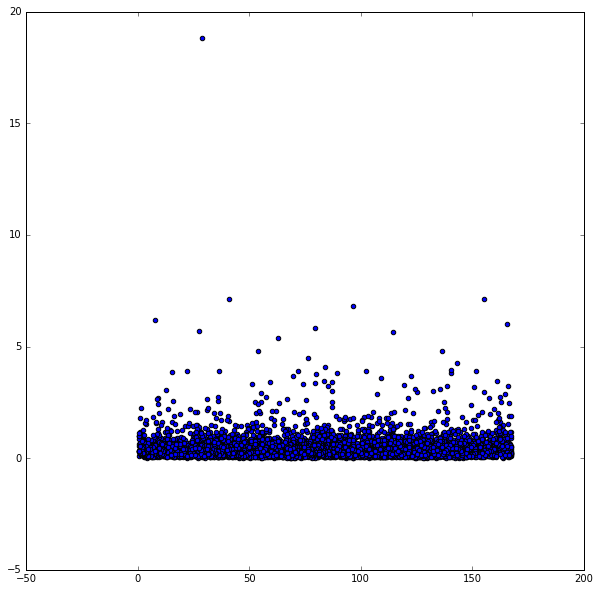

In [16]:
refined_peaks = reindex(indexed_peaks, refiner.batches())
plot_dq_vs_frame(refined_peaks)
plot_dx_vs_frame(refined_peaks)

sample position


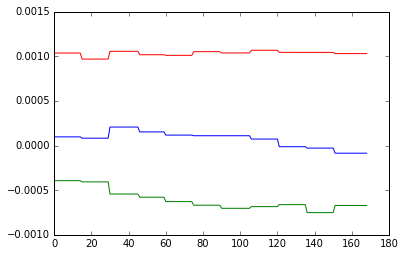

sample orientation perturbation


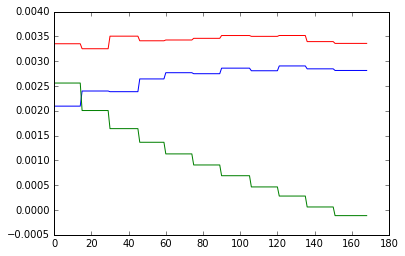

nx, ny


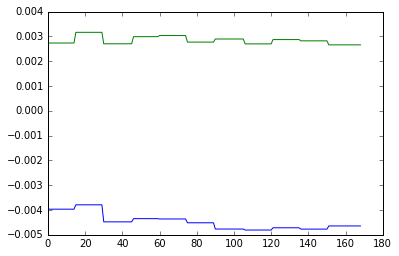

In [17]:
print("sample position")
plt.plot([state.samplePosition[0] for state in states])
plt.plot([state.samplePosition[1] for state in states])
plt.plot([state.samplePosition[2] for state in states])
plt.show()
    
print("sample orientation perturbation")
plt.plot([state.sampleOrientationOffset[0] for state in states])
plt.plot([state.sampleOrientationOffset[1] for state in states])
plt.plot([state.sampleOrientationOffset[2] for state in states])
plt.show()
    
print("nx, ny")
plt.plot([state.ni[0,0] for state in states])
#plt.plot([state.ni[0,1] for state in states])
plt.plot([state.ni[0,2] for state in states])
plt.show()

In [18]:
len(refined_peaks)
compute_statistics(refined_peaks, nsx.SpaceGroup("P 21 21 21"), True)

{'CChalf': 0.9921077670897327,
 'CCtrue': 0.9980171591801774,
 'Rmeas': 0.04631698671067603,
 'Rmerge': 0.03707108237743866,
 'Rpim': 0.027193672737600955}

In [19]:
#predicted = predict_peaks(data, refined_peaks)
#predicted.size()

In [20]:
peak_set = nsx.PeakSet()

for peak in refined_peaks:
    peak_set.insert(peak)

In [21]:
data.integratePeaks(peak_set, 3.5, 6.0, nsx.ProgressHandler())
compute_statistics(refined_peaks, nsx.SpaceGroup("P 21 21 21"), True)

{'CChalf': 0.9904937150918622,
 'CCtrue': 0.9976092207298253,
 'Rmeas': 0.04631698671067603,
 'Rmerge': 0.03707108237743866,
 'Rpim': 0.027193672737600955}

In [27]:
def predict_peaks(reference_peaks, data, dmin, dmax, B, batches):    
    pred = nsx.PeakPredictor(data)
    qshape = pred.averageQShape(reference_peaks)
    wavelength = data.getDiffractometer().getSource().getSelectedMonochromator().getWavelength()    
    hkls = uc.generateReflectionsInShell(dmin, dmax, wavelength)       
    prediction = pred.predictPeaks(hkls, B)
    
    good_pred = []
    
    for batch in batches:
        bcell = batch.cell()
        preds = pred.predictPeaks(hkls, bcell.reciprocalBasis())
        
        for p in preds:
            if not batch.contains(p.getShape().center()[2,0]):
                continue
                
            hkl = np.array([[0.,0.,0.]])
            
            if not bcell.getMillerIndices(p.getQ(), hkl):
                continue
                
            q = hkl.dot(bcell.reciprocalBasis())
            shape = nsx.Ellipsoid(q.transpose(), qshape)
            try:
                shape = pred.toDetectorSpace(shape)
            except:
                continue
                
            p.setShape(shape)                
            p.addUnitCell(bcell, True)
            good_pred.append(p)
    
    return good_pred
    
predicted = predict_peaks(refined_peaks, data, 2.0, 50.0, uc.reciprocalBasis(), refiner.batches())

In [29]:
peak_set = nsx.PeakSet()

for peak in predicted:
    peak_set.insert(peak)

data.integratePeaks(peak_set, 3.5, 6.0, nsx.ProgressHandler())
compute_statistics(predicted, nsx.SpaceGroup("P 21 21 21"), True)

{'CChalf': 0.9360199047327548,
 'CCtrue': 0.9833375666073999,
 'Rmeas': 0.18511594578735852,
 'Rmerge': 0.15121365265293668,
 'Rpim': 0.10438238414789516}

In [28]:
len(predicted)

35198

In [ ]:
nsx.vectorRowVector3d